In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
import geopandas as gpd
import sys 
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import dask.dataframe as dd
import pyarrow
import seaborn as sns



/mnt/c/Users/mezam/Desktop/visualizacion/visualization-course-materials/chiri/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
load_dotenv()

INPUTH_PATH = Path(os.getenv("INPUTH_PATH")).resolve()
CARTO_PATH = Path(os.getenv("CARTO_PATH")).resolve()
CHIRICOCA_PATH = Path(os.getenv("CHIRICOCA_PATH")).resolve()
AVES_PATH = Path(os.getenv("AVES_PATH")).resolve()

sys.path.append(str(CHIRICOCA_PATH))
sys.path.append(str(AVES_PATH))

In [3]:
import sys, os
print("AVES_PATH:", AVES_PATH)
print("Contenido de AVES_PATH:", os.listdir(AVES_PATH))

print("¿Está 'aves' aquí?:", 'aves' in os.listdir(AVES_PATH))


AVES_PATH: /mnt/c/Users/mezam/Desktop/visualizacion/aves/src
Contenido de AVES_PATH: ['aves']
¿Está 'aves' aquí?: True


In [4]:
from chiricoca.config import setup_style

setup_style()

In [5]:
from aves.models.grid import H3Grid

/mnt/c/Users/mezam/Desktop/visualizacion/visualization-course-materials/chiri/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SIET-Chile_04Dic2025_Publicacion.gdb': 'SIET_CULTURAL' (default), 'SIET_ECONOMICA', 'SIET_AMBIENTAL', 'SIET_SOCIAL'. Specify layer parameter to avoid this warning.
  result = read_func(
/mnt/c/Users/mezam/Desktop/visualizacion/visualization-course-materials/chiri/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts.  The processing may be really slow.  You can skip the processing by setting METHOD=SKIP.
  return ogr_read(


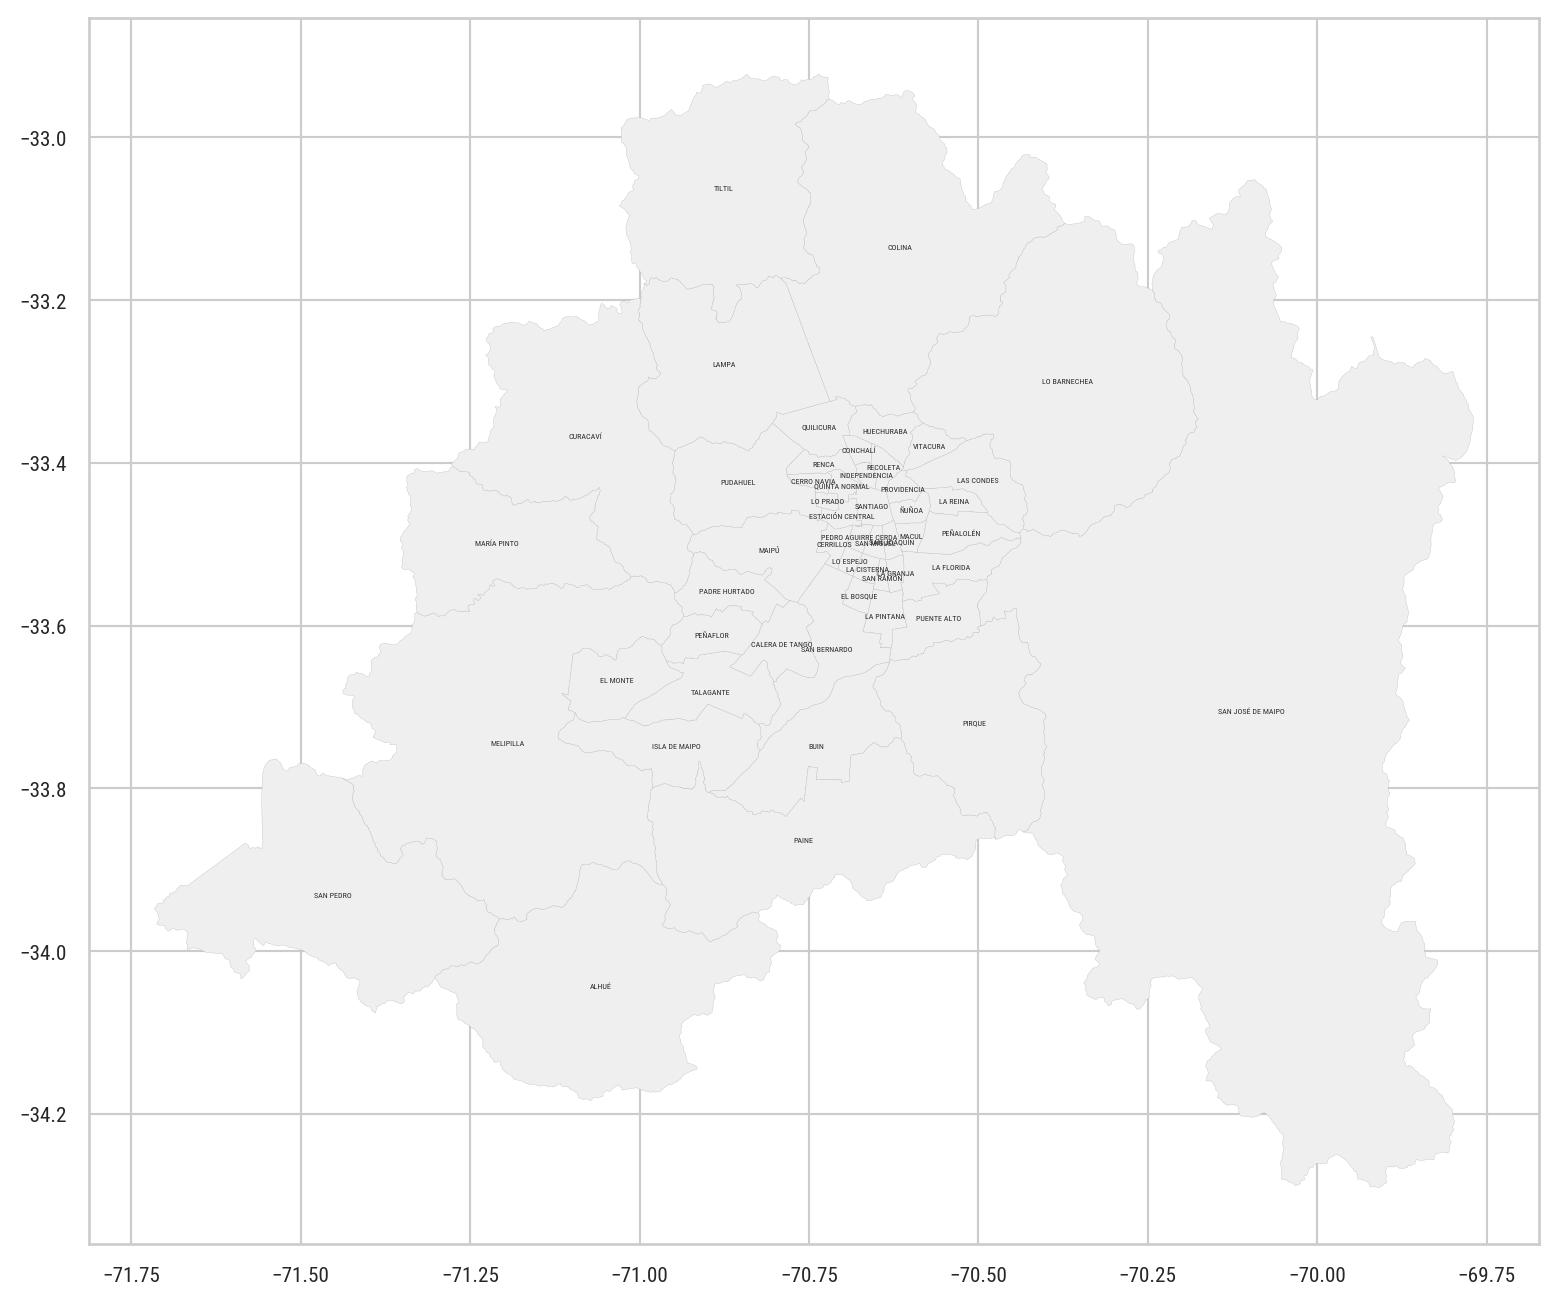

In [6]:
carto = gpd.read_file(CARTO_PATH)
#carto[carto['COD_REG'] == '13'].plot(edgecolor='#abacab', facecolor='#efefef', linewidth=0.1)

fig, ax = plt.subplots(figsize=(8, 8))

rm = carto[carto['COD_REG'] == '13']  # Región Metropolitana

rm.plot(ax=ax, edgecolor='#abacab', facecolor='#efefef', linewidth=0.1)

for idx, row in rm.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, row['COMUNA'], fontsize=3, ha='center', va='center')

In [7]:
carto.head(5)

,CUT,COD_REG,REGION,COD_PROV,PROVINCIA,COD_COM,COMUNA,MEDICION,ORDEN_MED,CLT_04,SHAPE_Length,SHAPE_Area,geometry
0,1101.0,1,01 TARAPACÁ,11,IQUIQUE,1101,IQUIQUE,Línea base,1.0,0.08,3.789837,0.198749,"MULTIPOLYGON (((-70.13266 -20.06332, -70.09894..."
1,1107.0,1,01 TARAPACÁ,11,IQUIQUE,1107,ALTO HOSPICIO,Línea base,1.0,0.07,0.952522,0.049622,"MULTIPOLYGON (((-69.91377 -20.22901, -69.94461..."
2,1401.0,1,01 TARAPACÁ,14,DEL TAMARUGAL,1401,POZO ALMONTE,Línea base,1.0,0.39,6.688255,1.195252,"MULTIPOLYGON (((-68.99311 -19.91994, -68.98631..."
3,1402.0,1,01 TARAPACÁ,14,DEL TAMARUGAL,1402,CAMIÑA,Línea base,1.0,1.45,2.114811,0.189286,"MULTIPOLYGON (((-69.39485 -19.06219, -69.38991..."
4,1403.0,1,01 TARAPACÁ,14,DEL TAMARUGAL,1403,COLCHANE,Línea base,1.0,0.63,3.091394,0.344852,"MULTIPOLYGON (((-68.95021 -18.93674, -68.92 -1..."


In [8]:
cl = dd.read_parquet( INPUTH_PATH / "personas-20251204T210904Z-3-001/personas", ) 

cod_territorial = pd.read_csv(INPUTH_PATH /'codigos_territoriales.csv', index_col=0) # Código territorial	Territorio
territorios_chile = cod_territorial["Territorio"].to_dict() 

cod_territorial_esp = pd.read_csv(INPUTH_PATH /'cod_territoriales_especificos.csv', index_col=0) 
territorios = cod_territorial_esp["Territorio específico"].to_dict() 

cl = cl.assign(comuna = cl['comuna'].map(territorios_chile))
cl = cl.assign(p24_lug_resid5_esp = cl['p24_lug_resid5_esp'].map(territorios))


/mnt/c/Users/mezam/Desktop/visualizacion/visualization-course-materials/chiri/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:4215: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('comuna', 'object'))

  warnings.warn(meta_warning(meta, method="map"))
/mnt/c/Users/mezam/Desktop/visualizacion/visualization-course-materials/chiri/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:4215: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `m

In [9]:
cl1 = cl[['id_vivienda', 'comuna', 'p24_lug_resid5_esp']]

cl1.head(10)

,id_vivienda,comuna,p24_lug_resid5_esp
0,54675,Iquique,Iquique
1,54675,Iquique,Iquique
2,54702,Iquique,Iquique
3,54702,Iquique,Iquique
4,54782,Iquique,Iquique
5,54782,Iquique,Bolivia (Estado Plurinacional de)
6,54782,Iquique,Iquique
7,54782,Iquique,Iquique
8,54926,Alto Hospicio,Alto Hospicio
9,54940,Iquique,Iquique


In [10]:
nombres_esp = set(territorios.values())          # nombres de territorios específicos
nombres_chile = set(territorios_chile.values())  # nombres de comunas de Chile
nombres_no_chile = nombres_esp - nombres_chile
nombres_no_chile


{'América del Norte',
 'Argentina',
 'Asia',
 'Aysén del General Carlos Ibáñez del Campo',
 'Bolivia (Estado Plurinacional de)',
 'Chile',
 'Colombia',
 'Europa',
 'Haití',
 'Los Ríos',
 'Oceanía',
 'Otros países de América Central y El Caribe',
 'Otros países de América del Sur',
 'Perú',
 'Varias comunas o países',
 'Venezuela (República Bolivariana de)',
 'África'}

In [11]:
cl_filtrado = cl[ cl['p24_lug_resid5_esp'].isin(nombres_chile) ]

In [12]:
vc = cl_filtrado['p24_lug_resid5_esp'].value_counts().compute().sort_index()
vc_mapeado = vc.rename(index=territorios)
vc_mapeado.head(40)

p24_lug_resid5_esp
Algarrobo              12529
Alhué                   6226
Alto Biobío             6000
Alto Hospicio         106495
Alto del Carmen         4432
Ancud                  38113
Andacollo              10744
Angol                  49331
Antofagasta           364856
Antuco                  4009
Antártica                100
Arauco                 34816
Arica                 218597
Arica y Parinacota        12
Atacama                   23
Aysén                  21978
Biobío                   175
Buin                   96469
Bulnes                 20558
Cabildo                18885
Cabo de Hornos          1525
Cabrero                27839
Calama                157220
Calbuco                32288
Caldera                16466
Calera                 48076
Calera de Tango        23824
Calle Larga            13922
Camarones                785
Camiña                  1292
Canela                  8730
Carahue                23004
Cartagena              20124
Casablanca             2

In [13]:
#cl_filtrado.to_parquet(INPUTH_PATH / "personas-20251204T210904Z-3-001/migracion_interna_dd", write_index=False)
#cl = dd.read_parquet( INPUTH_PATH / "personas-20251204T210904Z-3-001/personas", ) 


### FLOWMAP 

In [14]:
od = cl.groupby(['p24_lug_resid5_esp', 'comuna']).size().compute()
od = od.reset_index()
od.columns = ['origen', 'destino', 'n']


In [15]:
import unidecode

od['origen']  = od['origen'].astype(str).str.upper().apply(unidecode.unidecode)
od['destino'] = od['destino'].astype(str).str.upper().apply(unidecode.unidecode)
carto['COMUNA'] = carto['COMUNA'].astype(str).str.upper().apply(unidecode.unidecode)


In [16]:
comunas_validas = set(carto['COMUNA'])
od = od[
    od['origen'].isin(comunas_validas) &
    od['destino'].isin(comunas_validas)
]


In [17]:
od.head()

,origen,destino,n
0,ALGARROBO,ALTO HOSPICIO,1
1,ALGARROBO,ANTOFAGASTA,11
2,ALGARROBO,CALAMA,1
3,ALGARROBO,COPIAPO,7
4,ALGARROBO,COQUIMBO,17


In [18]:
carto['centroid'] = carto.geometry.centroid


/tmp/ipykernel_1964/2716525748.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carto['centroid'] = carto.geometry.centroid


In [19]:
od = od.merge(
    carto[['COMUNA', 'centroid']],
    left_on='origen',
    right_on='COMUNA',
    how='left'
).rename(columns={'centroid': 'geom_origen'})


In [20]:
od = od.merge(
    carto[['COMUNA', 'centroid']],
    left_on='destino',
    right_on='COMUNA',
    how='left'
).rename(columns={'centroid': 'geom_destino'})


In [21]:
from shapely.geometry import LineString

mask = od['geom_origen'].notna() & od['geom_destino'].notna()
od_clean = od.loc[mask].copy()

geoms = [
    LineString([o, d])
    for o, d in zip(od_clean['geom_origen'], od_clean['geom_destino'])
]

In [22]:
def dentro_chile_continental(point):
    return (
        -78 < point.x < -66 and
        -56 < point.y < -17
    )

### Filtro

In [105]:
od_clean['flow_geom'] = geoms

od_gdf = gpd.GeoDataFrame(od_clean, geometry='flow_geom', crs=carto.crs)
od_gdf = od_gdf[od_gdf["n"] > 100]
od_gdf.head()

,origen,destino,n,COMUNA_x,geom_origen,COMUNA_y,geom_destino,flow_geom
34,ALTO HOSPICIO,ALTO HOSPICIO,99082,ALTO HOSPICIO,POINT (-70.01264 -20.18975),ALTO HOSPICIO,POINT (-70.01264 -20.18975),"LINESTRING (-70.01264 -20.18975, -70.01264 -20..."
37,ALTO HOSPICIO,ANTOFAGASTA,151,ALTO HOSPICIO,POINT (-70.01264 -20.18975),ANTOFAGASTA,POINT (-69.40531 -24.27821),"LINESTRING (-70.01264 -20.18975, -69.40531 -24..."
46,ALTO HOSPICIO,COQUIMBO,160,ALTO HOSPICIO,POINT (-70.01264 -20.18975),COQUIMBO,POINT (-71.35846 -30.22744),"LINESTRING (-70.01264 -20.18975, -71.35846 -30..."
47,ALTO HOSPICIO,HUARA,104,ALTO HOSPICIO,POINT (-70.01264 -20.18975),HUARA,POINT (-69.66339 -19.60167),"LINESTRING (-70.01264 -20.18975, -69.66339 -19..."
50,ALTO HOSPICIO,IQUIQUE,3106,ALTO HOSPICIO,POINT (-70.01264 -20.18975),IQUIQUE,POINT (-70.04816 -20.92559),"LINESTRING (-70.01264 -20.18975, -70.04816 -20..."


In [106]:
od_gdf = od_gdf[
    od_gdf['geom_origen'].apply(dentro_chile_continental) &
    od_gdf['geom_destino'].apply(dentro_chile_continental)
]

In [107]:
rm = carto[carto['COD_REG'] == '13']  # Región Metropolitana
comunas_rm = rm['COMUNA'].unique()
od_gdf = od_gdf[od_gdf['destino'].isin(comunas_rm)]


In [108]:
flows = (
    od_gdf
    [['origen', 'destino', 'n']]
    .groupby(['origen', 'destino'], as_index=False)['n']
    .sum()
    .rename(columns={
        'origen': 'origin',
        'destino': 'dest',
        'n': 'count'
    })
)
flows.to_csv(INPUTH_PATH / "flows.csv", index=False)
flows.head()


,origin,dest,count
0,ALHUE,ALHUE,5784
1,ANTOFAGASTA,BUIN,106
2,ANTOFAGASTA,COLINA,370
3,ANTOFAGASTA,CONCHALI,113
4,ANTOFAGASTA,EL BOSQUE,130


In [109]:
carto_nodes = carto.copy()
carto_nodes['centroid'] = carto_nodes.geometry.centroid
carto_nodes['lon'] = carto_nodes['centroid'].x
carto_nodes['lat'] = carto_nodes['centroid'].y

locations = carto_nodes[['COMUNA', 'lat', 'lon']].rename(
    columns={'COMUNA': 'id'}
)
locations['name'] = locations['id']  # opcional

locations.to_csv(INPUTH_PATH / "locations.csv", index=False)

locations.head()

/tmp/ipykernel_1964/3057535419.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carto_nodes['centroid'] = carto_nodes.geometry.centroid


,id,lat,lon,name
0,IQUIQUE,-20.925585,-70.048158,IQUIQUE
1,ALTO HOSPICIO,-20.189748,-70.012639,ALTO HOSPICIO
2,POZO ALMONTE,-20.772205,-69.507971,POZO ALMONTE
3,CAMINA,-19.369995,-69.501131,CAMINA
4,COLCHANE,-19.354457,-68.844981,COLCHANE


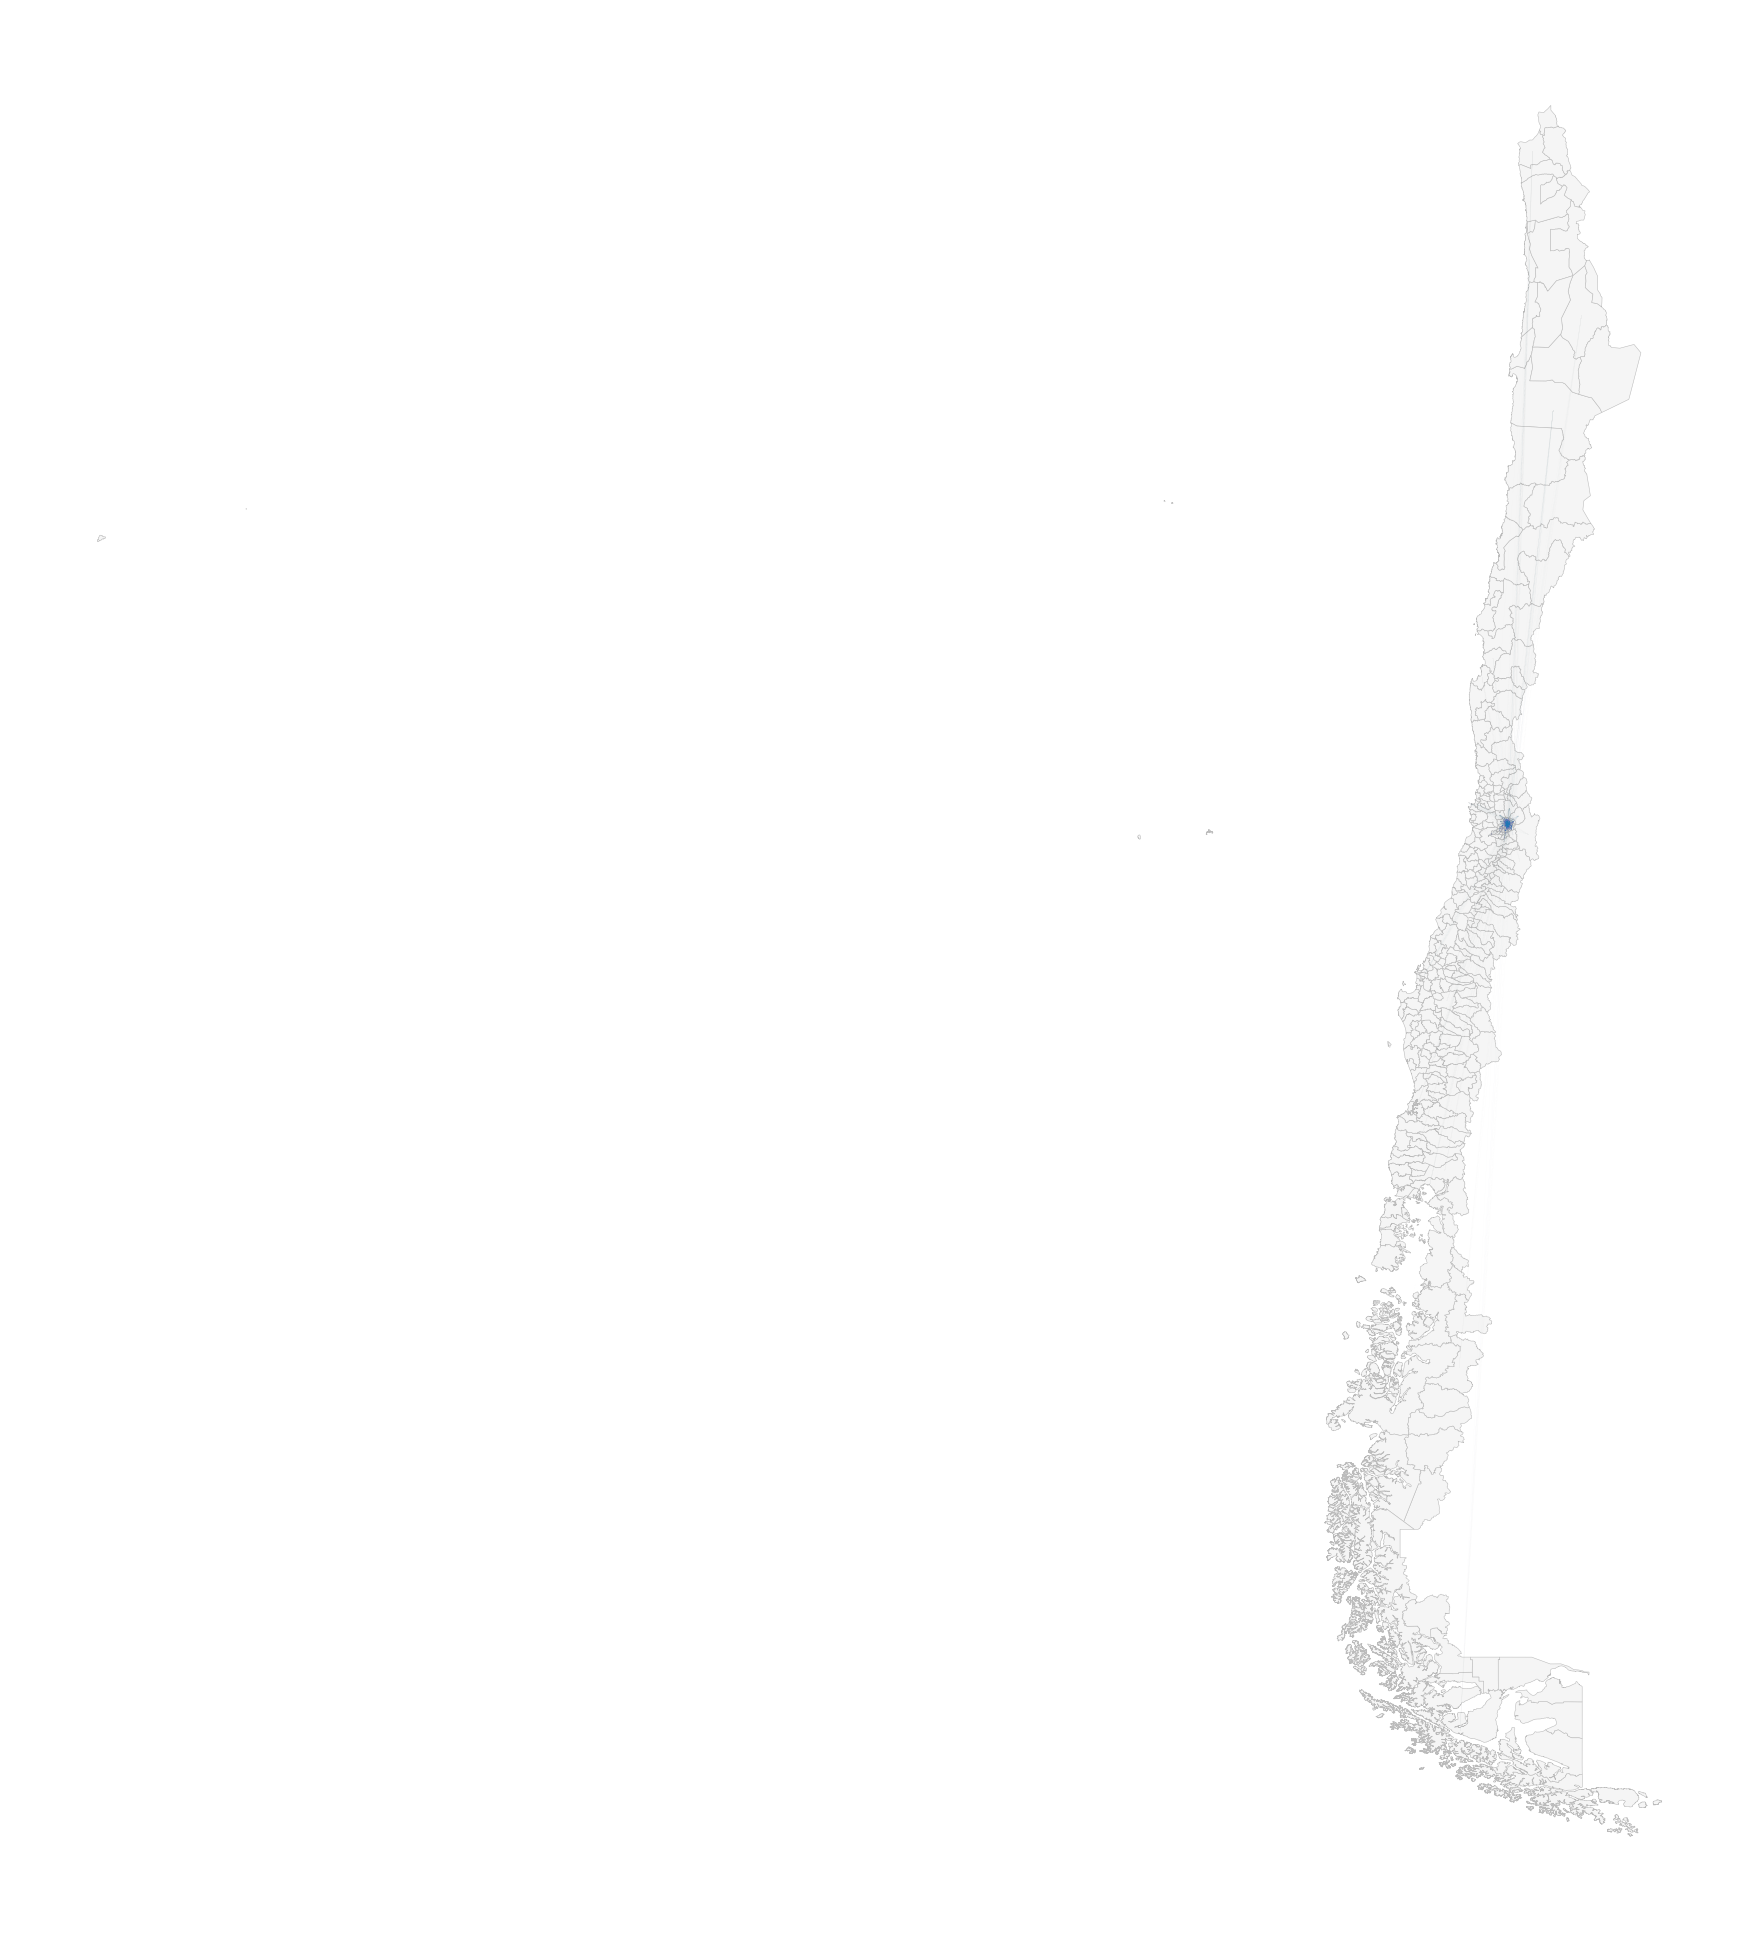

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))

carto.plot(ax=ax, edgecolor='#bbbbbb', facecolor='#f5f5f5', linewidth=0.2)

od_gdf.plot(
    ax=ax,
    linewidth=od_gdf['n'] / od_gdf['n'].max() * 3,
    alpha=0.6
)

ax.set_axis_off()
plt.show()


filtro

In [ ]:
rm = carto[carto['COD_REG'] == '13']  # Región Metropolitana